In [5]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
dv002.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [6]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

True

In [7]:
%autoreload

cohort = mre_pinn.data.PatientCohort(xarray_dir='../data/NAFLD', patient_ids='0006')
#cohort.create_xarrays()
#cohort.save_xarrays()
#cohort.metadata
cohort.load_xarrays()

  0%|          | 0/1 [00:00<?, ?it/s]Loading ../data/NAFLD/0006/t1_pre_in.nc
Loading ../data/NAFLD/0006/t1_pre_water.nc
Loading ../data/NAFLD/0006/t1_pre_out.nc
Loading ../data/NAFLD/0006/t1_pre_fat.nc
Loading ../data/NAFLD/0006/t2.nc
Loading ../data/NAFLD/0006/mre_raw.nc
Loading ../data/NAFLD/0006/wave.nc
Loading ../data/NAFLD/0006/mre.nc
Loading ../data/NAFLD/0006/mask.nc
100%|██████████| 1/1 [00:00<00:00, 26.19it/s]


In [8]:
pde = mre_pinn.pde.WaveEquation.from_name('helmholtz', detach=True)
pde

In [102]:
%autoreload
data = mre_pinn.training.PINOData(cohort, pde)
inputs, targets = data.train_next_batch(1)

In [103]:
[(x.shape, x.dtype) for x in inputs]

[(torch.Size([1, 256, 256, 16, 4]), torch.float32),
 (torch.Size([1, 256, 256, 16, 3]), torch.float32),
 (torch.Size([1, 256, 256, 4, 3]), torch.float32)]

In [104]:
targets.shape, targets.dtype

(torch.Size([1, 256, 256, 4, 1]), torch.float32)

In [108]:
%autoreload

pino = mre_pinn.model.pino.SpectralAttention(
    n_spatial_dims=3,
    n_channels_in=4,
    n_channels_out=1,
    n_modes=128
)
pino

SpectralAttention(n_spatial_dims=3, n_channels_in=4, n_channels_out=1, n_modes=128)

(256, 256, 4)


<IPython.core.display.Javascript object>


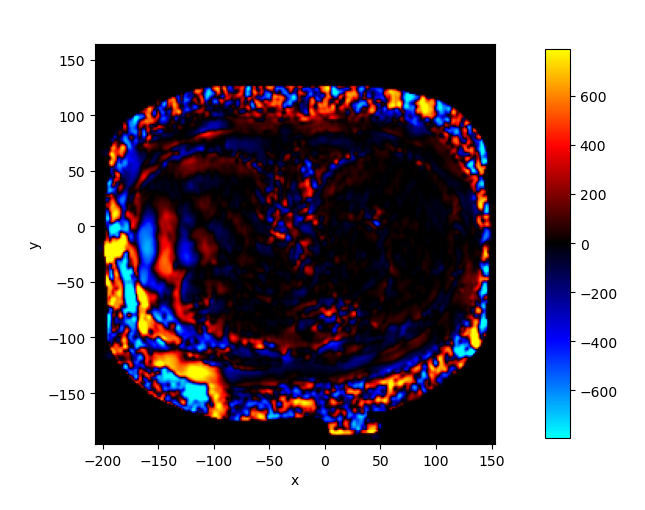

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [109]:
u_true = targets[0,...,0].detach().cpu().numpy()
print(cohort[0].arrays['wave'].shape)
u_true = mre_pinn.utils.as_xarray(u_true, like=cohort[0].arrays['wave'])

mre_pinn.visual.XArrayViewer(u_true)

<IPython.core.display.Javascript object>


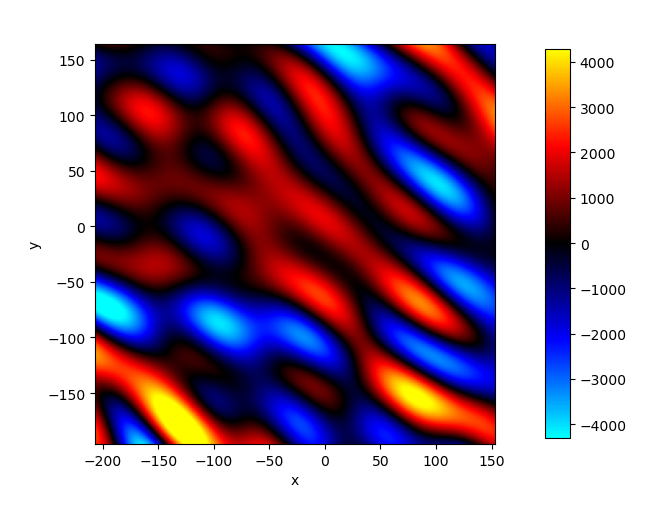

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [110]:
%autoreload

with torch.no_grad():
    u_pred = pino(inputs)[0,...,0].detach().cpu().numpy()
    u_pred = mre_pinn.utils.as_xarray(u_pred, like=cohort[0].arrays['wave'])

mre_pinn.visual.XArrayViewer(u_pred)

In [111]:
%autoreload

model = mre_pinn.training.PINOModel(cohort, pino, pde, batch_size=1)
model.compile(
    optimizer='adam',
    lr=1e-4,
    loss_weights=[1e-8, 1e0],
    loss=mre_pinn.training.losses.standardized_msae_loss_fn(u_true.values)

Compiling model...
'compile' took 0.000184 s



In [64]:
model.train(10000)

Training model...

Step      Train loss              Test loss               Test metric
0         [5.81e-08, 5.81e+00]    [5.81e-08, 5.81e+00]    []  
1000      [9.98e-09, 9.98e-01]    [9.98e-09, 9.98e-01]    []  


KeyboardInterrupt: 